# Whatsapp Group Chat Data Analysis using python.

Hey there! This a project which would keep evolving with time.

A typical data science project would involve 5 steps. The first step is Data Collection. In this case Data collection involves

Opening Whatsapp group chat.
Go to Settings.
Click on Export Chat.
Click on without media.

In [1]:
!pip install emoji

     |████████████████████████████████| 133kB 7.8MB/s 


In [1]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
% matplotlib inline

In [3]:
! git clone https://github.com/amueller/word_cloud.git
% cd word_cloud
! pip install .

Cloning into 'word_cloud'...
remote: Enumerating objects: 6459, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 6459 (delta 8), reused 6 (delta 0), pack-reused 6441
Receiving objects: 100% (6459/6459), 116.93 MiB | 31.10 MiB/s, done.
Resolving deltas: 100% (3839/3839), done.
/content/word_cloud
Processing /content/word_cloud
  Created wheel for wordcloud: filename=wordcloud-1.8.1.post3+g0b3b942-cp37-cp37m-linux_x86_64.whl size=333127 sha256=d2e72de9afe32d4552e08712d518479f2396c6f089c977bb0f373ac70fd14e14
  Stored in directory: /tmp/pip-ephem-wheel-cache-dt0qeis3/wheels/c9/9e/fe/b14c026a2af072dcf59543bce68dcdfff8a5362e6bb11242d9
Successfully built wordcloud
  Found existing installation: wordcloud 1.5.0
    Uninstalling wordcloud-1.5.0:
      Successfully uninstalled wordcloud-1.5.0


# **Data Preparation:**


This plain text file will have to be parsed and tokenized in a meaningful manner in order to be served (stored) in a Pandas dataframe.

Let us consider just a single line from the text (which we will call “raw text”) and see how we can extract relevant columns from it:

18/06/17, 9:47 PM - Teja: Why do you have 2 numbers?

In our sample line of text, our main objective is to automatically break down the raw message into 4 tokens.

{Date}, {Time} - {Author}: {Message}

{18/06/17}, {9:47 PM} - {Teja}: {Why do you have 2 numbers?}






In [2]:
def startsWithDateAndTimeAndroid(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -' 
    result = re.match(pattern, s)
    if result:
        return True
    return False

def startsWithDateAndTimeios(s):
    pattern = '^\[([0-9]+)([\/-])([0-9]+)([\/-])([0-9]+)[,]? ([0-9]+):([0-9][0-9]):([0-9][0-9])?[ ]?(AM|PM|am|pm)?\]' 
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [3]:
def FindAuthor(s):
  s=s.split(":")
  if len(s)==2:
    return True
  else:
    return False

In [4]:
def getDataPointAndroid(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(':') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

def getDataPointios(line):
	splitLine = line.split('] ')
	dateTime = splitLine[0]
	if ',' in dateTime:
		date, time = dateTime.split(',')
	else:
		date, time = dateTime.split(' ')
	message = ' '.join(splitLine[1:])
	if FindAuthor(message):
		splitMessage = message.split(':')
		author = splitMessage[0]
		message = ' '.join(splitMessage[1:])
	else:
		author = None
	if time[5]==":":
		time = time[:5]+time[-3:]
	else:
		if 'AM' in time or 'PM' in time:
			time = time[:6]+time[-3:]
		else:
			time = time[:6]
	return date, time, author, message


If you get a **Value Error** after running the below cell , it may be due to different format of date.

Try replacing %d-%m-%Y with %m-%d-%Y and replacing %d-%m-%y with %m-%d-%y and similarly for / too.

In [5]:
def dateconv(date):
  year=''
  if '-' in date:
    year = date.split('-')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d-%m-%Y").strftime("%Y-%m-%d")
    elif len(year) ==2:
      return datetime.datetime.strptime(date, "[%d-%m-%y").strftime("%Y-%m-%d")
  elif '/' in date:
    year = date.split('/')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d/%m/%Y").strftime("%Y-%m-%d")
    if len(year) ==2:
      return datetime.datetime.strptime(date, "[%d/%m/%y").strftime("%Y-%m-%d")

In [6]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

Change file path in the below cell

In [7]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = '/content/big_data_grp.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    device=''
    first=fp.readline()
    print(first)
    if '[' in first:
      device='ios'
    else:
      device="android"
    fp.readline() 
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        if device=="ios":
          line = line.strip()
          if startsWithDateAndTimeios(line):
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointios(line)
            messageBuffer.append(message)
          else:
            line= (line.encode('ascii', 'ignore')).decode("utf-8")
            if startsWithDateAndTimeios(line):
              if len(messageBuffer) > 0:
                parsedData.append([date, time, author, ' '.join(messageBuffer)])
              messageBuffer.clear()
              date, time, author, message = getDataPointios(line)
              messageBuffer.append(message)
            else:
              messageBuffer.append(line)
        else:
          line = line.strip()
          if startsWithDateAndTimeAndroid(line):
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointAndroid(line)
            messageBuffer.append(message)
          else:
            messageBuffer.append(line)

9/13/19, 10:34 AM - Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can read or listen to them. Tap to learn more.



In [8]:
if device =='android':
        df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.dropna()
        df["emoji"] = df["Message"].apply(split_count)
        URLPATTERN = r'(https?://\S+)'
        df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
else:
        df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
        df = df.dropna()
        df["Date"] = df["Date"].apply(dateconv)
        df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
        df["emoji"] = df["Message"].apply(split_count)
        URLPATTERN = r'(https?://\S+)'
        df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

In [9]:
df.head(2)

,Date,Time,Author,Message,emoji,urlcount
1,2019-09-13,10:37 AM,Akash Bro Au,Syllabus,[],0
2,2019-09-13,12:55 PM,Jc Au,Yaaaruu veetkuu pogadhingaaa please R4 vanga ...,[],0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12278 entries, 1 to 12544
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      12278 non-null  datetime64[ns]
 1   Time      12278 non-null  object        
 2   Author    12278 non-null  object        
 3   Message   12278 non-null  object        
 4   emoji     12278 non-null  object        
 5   urlcount  12278 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 671.5+ KB


## Printing Participants

In [11]:
df.Author.unique()

array(['Akash Bro Au', 'Jc Au', '+91 88703 81726', 'Uma Maheswari Au Bd',
       'Thulasi Bd Au', 'Abi Au Bd', 'Mahesh Au Bd', 'Muthukumar Au',
       'Rekha Au Bd', 'Monesh', 'Meenakshi Au Bd',
       'Sribharathi Akka Bd Au', 'Divya Au Bd', 'Priyanka Au Bd',
       'Anisha Au Bd', 'Mohana Akka Au Bd', '+91 96777 30314',
       'Sabari Au Bd', 'Uma Karpagam Au Bd', '+91 94883 65691',
       'Divya Kanadi Ponu Au Bd', '+91 98432 72551', 'Remitha Au Bd',
       '+91 97505 61567', 'Manimegalai Au Bd', 'Bharathi Akka Au Bd',
       '+91 7397 467 025', '+91 94459 45221', '+91 96770 13285'],
      dtype=object)

**None** which is the first element in array indicates few messages which do not have authors like,


*   Group was created.
*   Teja was added and so on.



Let us remove the messages created by None

In [12]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12278 entries, 1 to 12544
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      12278 non-null  datetime64[ns]
 1   Time      12278 non-null  object        
 2   Author    12278 non-null  object        
 3   Message   12278 non-null  object        
 4   emoji     12278 non-null  object        
 5   urlcount  12278 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 671.5+ KB


In [13]:
df.Author.unique()

array(['Akash Bro Au', 'Jc Au', '+91 88703 81726', 'Uma Maheswari Au Bd',
       'Thulasi Bd Au', 'Abi Au Bd', 'Mahesh Au Bd', 'Muthukumar Au',
       'Rekha Au Bd', 'Monesh', 'Meenakshi Au Bd',
       'Sribharathi Akka Bd Au', 'Divya Au Bd', 'Priyanka Au Bd',
       'Anisha Au Bd', 'Mohana Akka Au Bd', '+91 96777 30314',
       'Sabari Au Bd', 'Uma Karpagam Au Bd', '+91 94883 65691',
       'Divya Kanadi Ponu Au Bd', '+91 98432 72551', 'Remitha Au Bd',
       '+91 97505 61567', 'Manimegalai Au Bd', 'Bharathi Akka Au Bd',
       '+91 7397 467 025', '+91 94459 45221', '+91 96770 13285'],
      dtype=object)

We successfully removed None author.

# Group Wise Stats.

In [14]:
total_messages = df.shape[0]
print(total_messages)

12278


Let us now find out the total Media Messages

In [15]:
media_messages = df[df['Message'] == '<Media omitted>'].shape[0]
print(media_messages)

0


In [16]:
emojis = sum(df['emoji'].str.len())
print(emojis)

0


In [17]:
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()


In [18]:
links = np.sum(df.urlcount)

In [19]:
print("Group Wise Stats")
print("Messages:",total_messages)
print("Media:",media_messages)
print("Emojis:",emojis)
print("Links:",links)

Group Wise Stats
Messages: 12278
Media: 0
Emojis: 0
Links: 21


## Let us Separate the media messages and text messages

In [20]:
link_messages= df[df['urlcount']>0]
deleted_messages=df[(df["Message"] == " You deleted this message")| (df["Message"] == " This message was deleted.")|(df["Message"] == " You deleted this message.")]
media_messages_df = df[(df['Message'] == ' <Media omitted>')|(df['Message'] == ' image omitted')|(df['Message'] == ' video omitted')|(df['Message'] == ' sticker omitted')]
messages_df = df.drop(media_messages_df.index)
messages_df = messages_df.drop(deleted_messages.index)
messages_df = messages_df.drop(link_messages.index)

In [21]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10816 entries, 1 to 12542
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      10816 non-null  datetime64[ns]
 1   Time      10816 non-null  object        
 2   Author    10816 non-null  object        
 3   Message   10816 non-null  object        
 4   emoji     10816 non-null  object        
 5   urlcount  10816 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 591.5+ KB


It might be interesting to count the number of letters and words used by each author in each message. So, let us add 2 new columns to the data frame called “Letter_Count” and “Word_Count”, using the following code:

In [22]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df["MessageCount"]=1

In [23]:
messages_df.head(2)

,Date,Time,Author,Message,emoji,urlcount,Letter_Count,Word_Count,MessageCount
1,2019-09-13,10:37 AM,Akash Bro Au,Syllabus,[],0,9,2,1
2,2019-09-13,12:55 PM,Jc Au,Yaaaruu veetkuu pogadhingaaa please R4 vanga ...,[],0,141,25,1


In [24]:
messages_df["emojicount"]= df['emoji'].str.len()

#Author wise stats

In [25]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()

for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Words per message', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  #links consist of total links
  links = sum(link_messages[link_messages['Author'] == l[i]]["urlcount"])   
  print('Links Sent', links)   
  print()

Stats of Akash Bro Au -
Messages Sent 474
Words per message 8.30379746835443
Media Messages Sent 96
Emojis Sent 0
Links Sent 0

Stats of Jc Au -
Messages Sent 3039
Words per message 6.072721289897993
Media Messages Sent 342
Emojis Sent 0
Links Sent 3

Stats of +91 88703 81726 -
Messages Sent 107
Words per message 4.4953271028037385
Media Messages Sent 7
Emojis Sent 0
Links Sent 0

Stats of Uma Maheswari Au Bd -
Messages Sent 1802
Words per message 6.252497225305216
Media Messages Sent 164
Emojis Sent 0
Links Sent 6

Stats of Thulasi Bd Au -
Messages Sent 101
Words per message 4.079207920792079
Media Messages Sent 25
Emojis Sent 0
Links Sent 0

Stats of Abi Au Bd -
Messages Sent 716
Words per message 7.282122905027933
Media Messages Sent 107
Emojis Sent 0
Links Sent 1

Stats of Muthukumar Au -
Messages Sent 1663
Words per message 8.219482862297054
Media Messages Sent 147
Emojis Sent 0
Links Sent 5

Stats of Rekha Au Bd -
Messages Sent 224
Words per message 11.486607142857142
Media Messa

# Most used Emoji in Group

# Emoji Stats

### Unique emojis used in group

In [26]:
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(total_emojis)

0


### Most used emoji

In [27]:
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print(emoji_dict)

[]


In [28]:
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

,emoji,count


We can see '😂 '   dominates the list.

### Emoji distribution visualisation

In [ ]:
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### Person Wise Emoji Distribution

In [29]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  total_emojis_list = list([a for b in dummy_df.emoji for a in b])
  emoji_dict = dict(Counter(total_emojis_list))
  emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
  print('Emoji Distribution for', l[i])
  author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
  fig = px.pie(author_emoji_df, values='count', names='emoji')
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show()

Emoji Distribution for Akash Bro Au


Emoji Distribution for Jc Au


Emoji Distribution for +91 88703 81726


Emoji Distribution for Uma Maheswari Au Bd


Emoji Distribution for Thulasi Bd Au


Emoji Distribution for Abi Au Bd


Emoji Distribution for Muthukumar Au


Emoji Distribution for Rekha Au Bd


Emoji Distribution for Monesh


Emoji Distribution for Meenakshi Au Bd


Emoji Distribution for Sribharathi Akka Bd Au


Emoji Distribution for Divya Au Bd


Emoji Distribution for Priyanka Au Bd


Emoji Distribution for Anisha Au Bd


Emoji Distribution for Mohana Akka Au Bd


Emoji Distribution for +91 96777 30314


Emoji Distribution for Sabari Au Bd


Emoji Distribution for Mahesh Au Bd


Emoji Distribution for Uma Karpagam Au Bd


Emoji Distribution for +91 94883 65691


Emoji Distribution for Divya Kanadi Ponu Au Bd


Emoji Distribution for +91 98432 72551


Emoji Distribution for Remitha Au Bd


Emoji Distribution for +91 97505 61567


Emoji Distribution for Manimegalai Au Bd


Emoji Distribution for Bharathi Akka Au Bd


Emoji Distribution for +91 7397 467 025


Emoji Distribution for +91 96770 13285


# Some more Stats

### **Day wise Distribution**

In [30]:
def f(i):
  l = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  return l[i];
day_df=pd.DataFrame(messages_df["Message"])
day_df['day_of_date'] = messages_df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(f)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)

In [31]:
fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=False
)
fig.show()

### **Number of messages as times move on**

In [32]:
date_df = messages_df.groupby("Date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Date", y="MessageCount")
fig.update_xaxes(nticks=20)
fig.show()

In [33]:
date_df["rolling"] = date_df["MessageCount"].rolling(30).mean()
fig = px.line(date_df, x="Date", y="rolling")
fig.update_xaxes(nticks=20)
fig.show()

### **Chatter**

In [34]:
auth = messages_df.groupby("Author").sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Author", x="MessageCount", color='Author', orientation="h",
             color_discrete_sequence=["red", "green", "blue", "goldenrod", "magenta"],
             title="Explicit color sequence"
            )

fig.show()

### **When are the group members most active?**

Text(0, 0.5, 'Time')

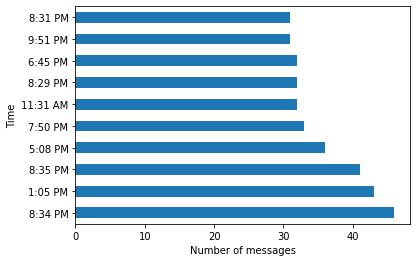

In [35]:
messages_df['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')

### **The most happening day was -**

2019-11-05    213
2020-03-16    206
2020-09-15    181
2020-03-29    177
2020-04-13    172
             ... 
2020-05-09      1
2021-01-10      1
2019-09-24      1
2021-04-20      1
2020-06-11      1
Name: Date, Length: 390, dtype: int64


Text(0, 0.5, 'Date')

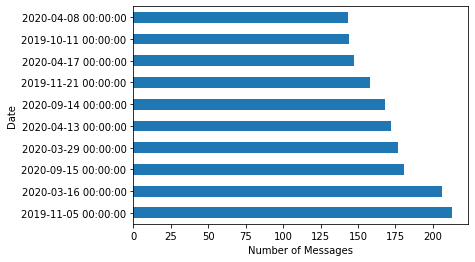

In [36]:
messages_df['Date'].value_counts().head(10).plot.barh()
print(messages_df['Date'].value_counts())
plt.xlabel('Number of Messages')
plt.ylabel('Date')

### **The early bird**

### The Late Owl

### **Message Having Maximum number of words**

In [37]:
messages_df.iloc[messages_df['Word_Count'].argmax()]

Date                                          2019-09-21 00:00:00
Time                                                      2:07 PM
Author                                              Muthukumar Au
Message          *Python Roadmap*  Let’s begin. Have a goal in...
emoji                                                          []
urlcount                                                        0
Letter_Count                                                11947
Word_Count                                                   1918
MessageCount                                                    1
emojicount                                                      0
Name: 260, dtype: object

### **Word Cloud**

In [38]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))

There are 361923 words in all the messages.


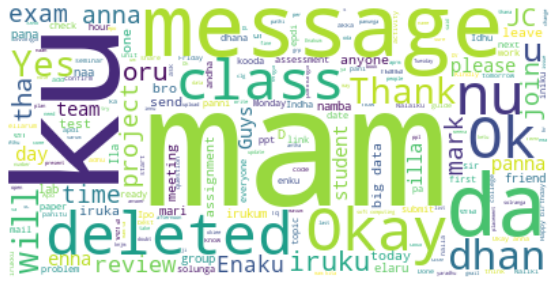

In [39]:
  stopwords = set(STOPWORDS)
  stopwords.update(["ra", "ga", "na", "ani", "em", "ki", "ah","ha","la","eh","ne","le","ni","lo","Ma","Haa","ni"])
  # Generate a word cloud image
  wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
  # Display the generated image:
  # the matplotlib way:
  
  plt.figure( figsize=(10,5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [ ]:
# REFERENCES LINKS

#--https://github.com/SinghalHarsh/WhatsApp-Chat-Analysis
#--https://github.com/kurasaiteja/Whatsapp-Analysis

''